In [1]:
import numpy as np
import yaml
import pprint
from pathlib import Path
import random
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from torch.nn import MSELoss
from torch.optim import Adam
from torch import nn
import matplotlib.pyplot as plt

In [2]:
TRAIN_SET_PATH = "../tdl_dataset/train/TDLA"
EPOCHS = 10
LR = 0.0001
LIMIT_DATA_SIZE = 10000
TRAIN_SNR_LEVELS = [0, 10, 20]

In [3]:
with open(Path(TRAIN_SET_PATH, "metadata.yaml"), "r") as f:
    train_metadata = yaml.safe_load(f)
print("=== TRAIN SET METADATA ===")
pprint.pprint(train_metadata)

=== TRAIN SET METADATA ===
{'config': {'carrier_freq': '3.5e9',
            'delay_profile': 'A',
            'delay_spreads': [25,
                              50,
                              75,
                              100,
                              125,
                              150,
                              175,
                              200,
                              225,
                              250,
                              275,
                              300],
            'max_doppler_shifts': [50,
                                   100,
                                   150,
                                   200,
                                   250,
                                   300,
                                   350,
                                   400,
                                   450,
                                   500,
                                   550,
                                   600,
     

In [4]:
class TDLDataset(Dataset):
    def __init__(
        self, data_path, *, file_size, return_pilots_only=True, num_subcarriers=120,
        num_time_slots=14, SNR_levels=[0, 5, 10, 15, 20, 25, 30],
        pilot_time_indices=[2, 11], pilot_freq_N=2):
        
        self.data_path = data_path
        self.file_size = int(file_size)
        self.num_subcarriers = num_subcarriers
        self.num_time_slots = num_time_slots
        self.SNR_levels = SNR_levels
        self.pilot_time_indices = pilot_time_indices
        self.pilot_freq_N = pilot_freq_N
        self.return_pilots_only = return_pilots_only

        self.file_list = list(Path(self.data_path).glob("*.npy"))
        self.stats = self._get_stats_per_file()
        self.pilot_mask = self._get_pilot_mask()

        self.num_pilot_time_inds = len(self.pilot_time_indices)
        self.num_pilot_subcarriers = int(self.pilot_mask.sum()) // self.num_pilot_time_inds

    def __len__(self):
        return len(self.file_list) * self.file_size

    def __getitem__(self, idx):
        file_idx = idx // self.file_size
        sample_idx = idx % self.file_size
        file_path = self.file_list[file_idx]
        data = np.load(file_path)
        channel = data[sample_idx].squeeze().T

        SNR = random.choice(self.SNR_levels)
        LS_channel_at_pilots = self._get_LS_estimate_at_pilots(channel, SNR)
        stats = self.stats[file_path]
        stats["SNR"] = SNR

        LS_channel_at_pilots_t = torch.from_numpy(LS_channel_at_pilots).to(torch.complex64)
        channel_t = torch.from_numpy(channel).to(torch.complex64)
        return LS_channel_at_pilots_t, channel_t, stats

    def _get_stats_per_file(self):
        stats = {}

        for file_path in self.file_list:
            file_name = str(file_path.stem)
            file_parts = file_name.split("_")

            if file_parts[0] == "delay":
                doppler_shift = int(file_parts[-1])  # doppler_x_delay_spread_y_.npy
                delay_spread = int(file_parts[2])
            elif file_parts[0] == "doppler":
                doppler_shift = int(file_parts[1])  # doppler_x_delay_spread_y_.npy
                delay_spread = int(file_parts[-2])
            else:
                raise ValueError(f"File {file_name} has unexpected format")
            
            if file_path not in stats:
                stats[file_path] = {"doppler_shift": doppler_shift, "delay_spread": delay_spread}
            else:
                raise ValueError(f"File {file_path} already in stats")
            
        return stats
    
    def _get_LS_estimate_at_pilots(self, channel_matrix, SNR):
        # unit symbol power and unit channel power --> rx noise var = LS error var
        noise_std = np.sqrt(1 / (10**(SNR / 10)))

        if self.return_pilots_only:
            pilot_mask_bool = self.pilot_mask.astype(bool)
            channel_at_pilots = channel_matrix[pilot_mask_bool]
            channel_at_pilots = channel_at_pilots.reshape(self.num_pilot_subcarriers, self.num_pilot_time_inds)
            noise = noise_std * np.random.randn(self.num_pilot_subcarriers, self.num_pilot_time_inds)
        else:
            channel_at_pilots = self.pilot_mask * channel_matrix
            noise = noise_std * np.random.randn(self.num_subcarriers, self.num_time_slots)
            noise = noise * self.pilot_mask
        
        channel_at_pilots_LS = channel_at_pilots + noise
            
        return channel_at_pilots_LS

    def _get_pilot_mask(self):
        pilot_mask = np.zeros((self.num_subcarriers, self.num_time_slots))
        pilot_mask_subcarrier_indices = np.arange(0, self.num_subcarriers, self.pilot_freq_N)
        pilot_mask[np.ix_(pilot_mask_subcarrier_indices, self.pilot_time_indices)] = 1
        return pilot_mask
        

In [5]:
# simple linear model
class LinearModel(nn.Module):
    def __init__(self, num_pilot_subcarriers, num_pilot_time_inds, num_subcarriers, num_time_slots):
        super(LinearModel, self).__init__()
        self.num_pilot_subcarriers = num_pilot_subcarriers
        self.num_pilot_time_inds = num_pilot_time_inds
        self.num_subcarriers = num_subcarriers
        self.num_time_slots = num_time_slots

        input_dim = num_pilot_subcarriers * num_pilot_time_inds
        output_dim = num_subcarriers * num_time_slots
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(dim=0)  # add batch dimension if not present
        x = x.view(x.size(0), -1)
        y = self.linear(x)
        y = y.view(x.size(0), self.num_subcarriers, self.num_time_slots)
        return y


In [6]:
large_dataset = TDLDataset(
    TRAIN_SET_PATH, 
    file_size=train_metadata["config"]["num_channels_per_config"],
    SNR_levels=TRAIN_SNR_LEVELS)

# sample a subset of the dataset for faster training
data_indices = np.random.choice(len(large_dataset), size=LIMIT_DATA_SIZE, replace=False)
sampled_dataset = Subset(large_dataset, data_indices)

print("Dataset size:", len(sampled_dataset))
dataloader = DataLoader(sampled_dataset, batch_size=512, shuffle=True)

model = LinearModel(
    large_dataset.num_pilot_subcarriers,
    large_dataset.num_pilot_time_inds,
    large_dataset.num_subcarriers,
    large_dataset.num_time_slots)

Dataset size: 10000


In [7]:
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=LR)
losses = []

for epoch in range(EPOCHS):
    for batch in dataloader:
        h_ls, h_true, stats = batch
        optimizer.zero_grad()
        h_hat_real = model(h_ls.real)
        h_hat_imag = model(h_ls.imag)
        loss1 = loss_fn(h_hat_real, h_true.real)
        loss2 = loss_fn(h_hat_imag, h_true.imag)
        loss = loss1 + loss2
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 1.3289302587509155
Epoch 1, Loss: 1.1964075565338135
Epoch 2, Loss: 1.1289594173431396
Epoch 3, Loss: 1.054449200630188
Epoch 4, Loss: 1.061661720275879
Epoch 5, Loss: 0.9887635707855225
Epoch 6, Loss: 1.0013608932495117
Epoch 7, Loss: 0.9629224538803101
Epoch 8, Loss: 0.9645572900772095
Epoch 9, Loss: 0.9499457478523254


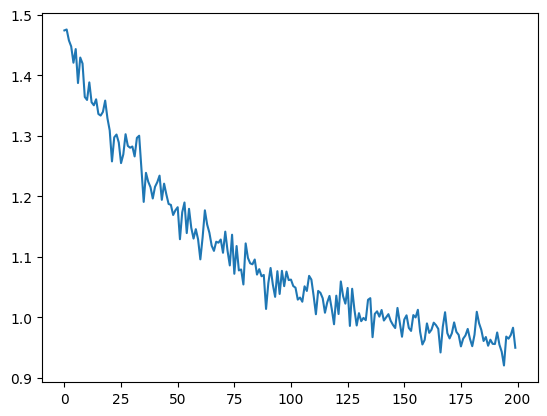

In [8]:
plt.plot(losses)
plt.show()